In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), "../../"))

In [2]:
import os

import matplotlib
print(matplotlib.__version__) 

from matplotlib.patches import FancyArrowPatch, Ellipse, Arc
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import librosa
import json

import constants as c
from readers.memo_ga import MEMOGroupAff
from utilities.plots import set_plot_params

from analysis.graphs.plots_arranger import FlowLayout

3.7.5


In [3]:
# Constants
dummy_dataobj = MEMOGroupAff()
graph_feats_pth = dummy_dataobj.features_folder + "/gatttn_wgts/"

In [4]:
from typing import Optional

import matplotlib.pyplot as plt
from matplotlib.path import Path as MplPath  # To avoid collisions with pathlib.Path
import matplotlib.patches as patches
import networkx as nx
import numpy as np


# Some useful functions
def normalize_vector(vector: np.array, normalize_to: float) -> np.array:
    """Make `vector` norm equal to `normalize_to`
    
    vector: np.array
        Vector with 2 coordinates
    
    normalize_to: float
        A norm of the new vector
        
    Returns
    -------
    Vector with the same direction, but length normalized to `normalize_to`
    """
    
    vector_norm = np.linalg.norm(vector)
    
    return vector * normalize_to / vector_norm


def orthogonal_vector(point: np.array, width: float, normalize_to: Optional[float] = None) -> np.array:
    """Get orthogonal vector to a `point`

    point: np.array
        Vector with x and y coordinates of a point

    width: float
        Distance of the x-coordinate of the new vector from the `point` (in orthogonal direction)

    normalize_to: Optional[float] = None
        If a number is provided, normalize a new vector length to this number
    
    Returns
    -------
    Array with x and y coordinates of the vector, which is orthogonal to the vector from (0, 0) to `point` 
    """
    EPSILON = 0.000001

    x = width
    y = -x * point[0] / (point[1] + EPSILON)

    ort_vector = np.array([x, y])

    if normalize_to is not None:
        ort_vector = normalize_vector(ort_vector, normalize_to)

    return ort_vector

def draw_self_loop(
    point: np.array,
    ax: Optional[plt.Axes] = None,
    padding: float = 1.5,
    width: float = 0.3,
    plot_size: int = 10,
    linewidth = 0.2,
    color: str = "pink",
    alpha: float = 0.5
) -> plt.Axes:
    """Draw a loop from `point` to itself

    !Important! By "center" we assume a (0, 0) point. If your data is centered around a different points,
    it is strongly recommended to center it around zero. Otherwise, you will probably get ugly plots

    Parameters
    ----------
    point: np.array
        1D array with 2 coordinates of the point. Loop will be drawn from and to these coordinates.
    padding: float = 1.5
        Controls how the distance of the loop from the center. If `padding` > 1, the loop will be
        from the outside of the `point`. If `padding` < 1, the loop will be closer to the center
    width: float = 0.3
        Controls the width of the loop
    linewidth: float = 0.2
        Width of the line of the loop
    ax: Optional[matplotlib.pyplot.Axes]:
        Axis on which to draw a plot. If None, a new Axis is generated
    plot_size: int = 7
        Size of the plot sides in inches. Ignored if `ax` is provided    
    color: str = "pink"
        Color of the arrow
    alpha: float = 0.5
        Opacity of the edge
    
    Returns
    -------
    Matplotlib axes with the self-loop drawn
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(plot_size, plot_size))
    
    point_with_padding = padding * point

    ort_vector = orthogonal_vector(point, width, normalize_to=width)

    first_anchor = ort_vector + point_with_padding
    second_anchor = -ort_vector + point_with_padding

    verts = [point, first_anchor, second_anchor, point]
    codes = [MplPath.MOVETO, MplPath.CURVE4, MplPath.CURVE4, MplPath.CURVE4]

    path = MplPath(verts, codes)

    patch = patches.FancyArrowPatch(
        path=path,
        facecolor='none',
        lw=linewidth,
        arrowstyle="-|>",
        color=color,
        alpha=alpha,
        mutation_scale=30  # arrowsize in draw_networkx_edges()
    )
    ax.add_patch(patch)

    return ax

In [ ]:
# Utilties

def get_edges(edge_index, edge_weights):
    edges = []
    for edge, weight in zip(edge_index, edge_weights):
        # print("edge between: ", edge[0], edge[1], "with weight: ", weight)
        edges.append((edge[0], edge[1], weight))
    return edges

def normalize_weights(weights, log_norm=True): 

    min_w, max_w = min(weights), max(weights)
    norm_weights = (weights - min_w) / (max_w - min_w)  # Normalize to range 0-1
    
    if log_norm:
        norm_weights = np.log(norm_weights + 1)  # Log-normalization
        
    return norm_weights


def extract_weights_for_viz(G, group_size, log_norm=True, edge_width_scale=[1, 8], edge_alpha_scale=0.2):
    
    num_dummy_nodes = len(G.nodes()) - group_size
    # print("#Dummy nodes: ", num_dummy_nodes)
    
    # Extract weights for visualization
    weights = np.array([data['weight'] for _, _, data in G.edges(data=True)])
    req_weights = weights if num_dummy_nodes == 0 else weights[:-1*num_dummy_nodes]  # Exclude dummy self-loops 
    
    # Normalize weights
    req_weights = (req_weights)  # Exponential scaling
    norm_weights = normalize_weights(req_weights, log_norm=log_norm)
    std_edge_weights = np.std(req_weights)
    
    # Normalize weights for width and alpha scaling
    edge_widths = edge_width_scale[0] + norm_weights * edge_width_scale[1]  # Scale for visibility (1 to 8)
    edge_alphas = edge_alpha_scale + norm_weights * (1-edge_alpha_scale)  # Alpha from 0.2 to 1

    for i in range(num_dummy_nodes):
        # Set the edge width and alpha for dummy nodes
        edge_widths = np.append(edge_widths, edge_width_scale[0])
        edge_alphas = np.append(edge_alphas, edge_alpha_scale)

    # Define edge colors with varying transparency: black edges with variable alpha
    edge_colors = [(0, 0, 0, alpha) for alpha in edge_alphas] 
    
    return edge_widths, edge_colors, std_edge_weights

def plot_graph(ax, nodes=[0, 1, 2],
                     edge_index=np.array([[0,1], [0,2], [1,2], [0,0], [1,1], [2,2]]),
                       edge_weights=[0.5,0.3,0.1,0.02,0.07,0.01], save_path=None, title="", group_size=6, log_norm=True, save=False, group_id="", fname=""):
    """
        Function to plot a tickz figure of graphs wiht nodes and edges
        Function takes a list of nodes, edge_index and edge_weights
        and plots the graph using networkx and tikzplotlib
        
        Parameters:
            nodes (list): List of nodes in the graph
            edge_index (list): List of edges in the graph
            edge_weights (list): List of edge weights
            save_path (str): Path to save the figure
        
        Returns:
            fig (matplotlib.figure.Figure): Figure object
    """

    # Create a weighted graph
    G = nx.Graph()
    
    # **************** For Paper **************** 
    # node_size = 50000
    # node_font_size = 150
    # # Extract edge widths and colors for vizualization
    # ## Constants
    # edge_width_scale = [4, 24]  # Scale for visibility (4 to 25)
    # edge_alpha_scale = 0.2  # Alpha from 0.2 to 1
    # legend_font_size = 72
    # legend_patch_size = edge_width_scale[1]/20
    
    # **************** For analysis **************** 
    node_size = 2000
    node_font_size = 18
    ## Extract edge widths and colors for vizualization
    ### Constants
    edge_width_scale = [1, 7]  # Scale for visibility (1 to 8)
    edge_alpha_scale = 0.2  # Alpha from 0.2 to 1
    legend_font_size = 11
    legend_patch_size = edge_width_scale[1]/20
    
    # Add nodes
    G.add_nodes_from(nodes)
    # Add weighted edges (format: (node1, node2, weight))
    edges = get_edges(edge_index, edge_weights)
    G.add_weighted_edges_from(edges)
    
    assert len(G.nodes()) == len(nodes), "Number of NODES in the graph does not match the input nodes"
    assert len(G.edges()) == len(edges), "Number of EDGES in the graph does not match the input edges"
    
    # Draw graph
    pos = nx.circular_layout(G, scale=0.25)  # Circular layout

    nx.draw_networkx_nodes(G, pos, node_size=node_size, ax=ax)
    
    edge_widths, edge_colors, std_edge_weights = extract_weights_for_viz(G, group_size=group_size, log_norm=log_norm, edge_width_scale=edge_width_scale, edge_alpha_scale=edge_alpha_scale)

    # Set node width and color based in edge widths and edge colors
    # Set the code colors and node widths based on the edge indexes (if u==v)
    self_edge_colors = [color for (u, v, w), width, color in zip(edges, edge_widths, edge_colors) if u == v]
    self_edge_widths = [width for (u, v, w), width, color in zip(edges, edge_widths, edge_colors) if u == v]

    nx.draw_networkx_nodes(G, pos, node_size=node_size, ax=ax, linewidths=self_edge_widths, edgecolors=self_edge_colors)
    nx.draw_networkx_labels(G, pos, font_size=node_font_size, ax=ax)

    # Draw non-self loop edges with varying width and transparency, while skipping self-loops
    for (u, v, w), width, color in zip(edges, edge_widths, edge_colors):
        # print(u, v, w)
        # Also make the self-loop edges more longer and not intersecting with other edges
        if u != v:
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, edge_color=[color], ax=ax, arrows=False)
    
    # Remove border around the plot
    ax.axis("off")
    
    # add a legend of black line with label 
    legend_patch = patches.Patch(color='black', label=r'$\alpha_{ij}$', linewidth=legend_patch_size)
    ax.legend(handles=[legend_patch], bbox_to_anchor=(1.02, .99), bbox_transform=ax.transAxes, fontsize=legend_font_size, frameon=True)
    ax.margins(0.1)  # Optional: Add some margin around the plot
    
    if "high" in fname or "low" in fname or "med" in fname:
        print()
    else:
        pass
        # ax.set_title(title, fontsize=legend_font_size)
    
    if save:
        if "high" in fname or "low" in fname or "med" in fname:
            fldr_path = "plots/high_med_low/" + group_id + "/"
        else:
            fldr_path = "plots/dynamics/" + group_id + "/"        
        
        os.makedirs(fldr_path, exist_ok=True)
        print("saving @", fldr_path + fname + ".pdf")
        plt.savefig(fldr_path + fname + ".pdf", bbox_inches='tight')

    return ax

In [29]:
# Data utilities
def get_graph_data_for(group="4", session="1"):
    filepath = graph_feats_pth + f"group{group}_session{session}.json"
    # Read json as dict
    graph_data = json.load(open(filepath, "r"))
    return graph_data

def get_edge_data_for(group="4", session="1", onset="0", offset="15", edge_key="attn1", normalize=True, headagg_sum=False):

    graph_data = get_graph_data_for(group, session)
    # Get group size
    group_size = graph_data["group_size"]
    # Get edge index and edge weights
    graph_data = graph_data[onset+"_"+offset]
    edge_index = np.array(graph_data["edge_attn_dict"]["edge_index"])
    
    if edge_key == "avg":
        # Get average weights of all keys in graph_data["edge_attn_dict"]
        edge_weights = np.array([graph_data["edge_attn_dict"][key] for key in graph_data["edge_attn_dict"].keys() if key != "edge_index"])
        # Average weights
        edge_weights = np.mean(edge_weights, axis=0)
    elif edge_key == "sum":
        # Get sum weights of all keys in graph_data["edge_attn_dict"]
        edge_weights = np.array([graph_data["edge_attn_dict"][key] for key in graph_data["edge_attn_dict"]])
        # Sum weights
        edge_weights = np.sum(edge_weights, axis=0)
    else:
        # Get weights for the specific key
        edge_weights = np.array(graph_data["edge_attn_dict"][edge_key])

    # Aggregate weights : across attention heads
    if headagg_sum:
        # Sum weights across attention heads
        edge_weights = np.sum(edge_weights, axis=-1)
    else:
        # Average weights
        edge_weights = np.mean(edge_weights, axis=-1)
    # Normalize weights between 0 and 1
    # if normalize:
    #     edge_weights = (edge_weights - np.min(edge_weights)) / (np.max(edge_weights) - np.min(edge_weights))
    # Get ground-truth & predicted arousal and valence
    gt_dict = graph_data["gt_dict"]
    pred_dict = graph_data["pred_dict"]
    
    return edge_index, edge_weights, gt_dict, pred_dict, group_size


In [35]:
# Plotting utilities
def contiguous_plots(figsize, group, session, onsets, offsets, edge_key="attn1", normalize=False, headagg_sum=False, log_norm=False, save=False, mode=""):
    oPlot = FlowLayout() # create an empty FlowLayout

    # Get edge data for the first onset
    for i, (onset, offset) in enumerate(zip(onsets, offsets)):
        edge_index, edge_weights, gt_dict, pred_dict, group_size = get_edge_data_for(group, session, onset, offset, edge_key, normalize, headagg_sum)
        nodes = list(range(c.MAX_GROUP_SIZE))
    
        fig, ax = plt.subplots(1, 1, figsize=figsize) # same size plots
                            # figsize=(3+i/3,2+i/4)) # different size plots
        fig.patch.set_facecolor("white")    # Set the outer colour to white

        if "high" in mode or "low" in mode or "med" in mode:
            fname = str(i)+"_"+edge_key+"_"+mode
        else:
            fname = onset+"_"+offset
        
        ax = plot_graph(ax=ax, nodes=nodes, edge_index=edge_index, edge_weights=edge_weights, title="", group_size=group_size, log_norm=log_norm,
                        save=save, group_id=group+"_"+ session, fname=fname)

        oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
        plt.close() # this gets rid of the plot so it doesn't appear in the cell

    oPlot.PassHtmlToCell()

# Segment-wise Graph 
#### [High-Medium-Low arousal and Valence]


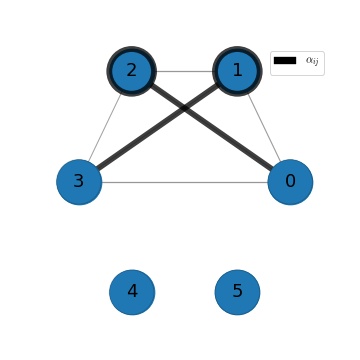
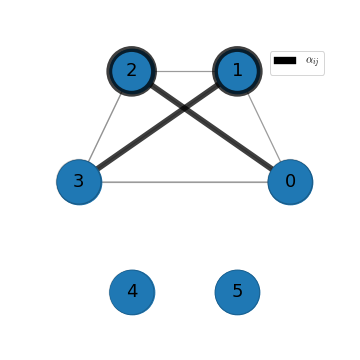
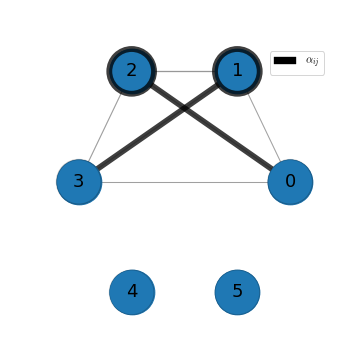
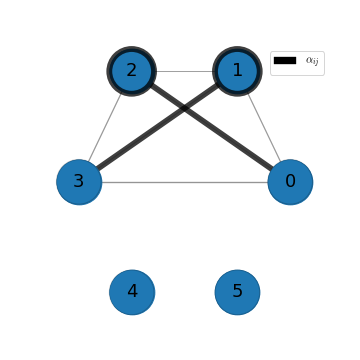
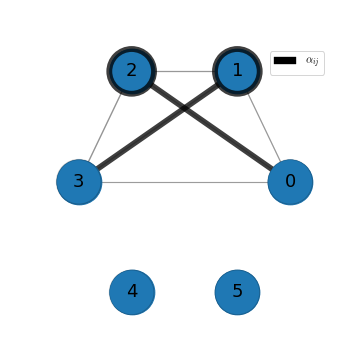
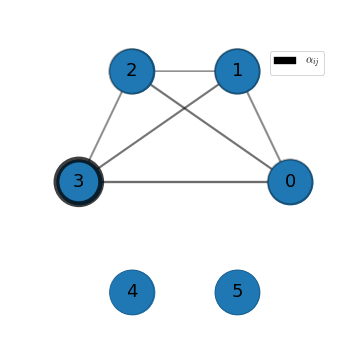
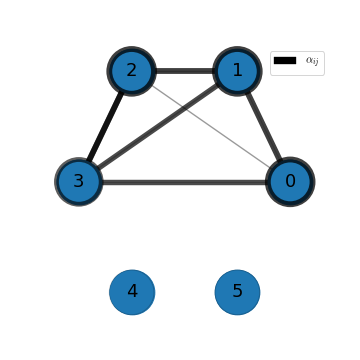
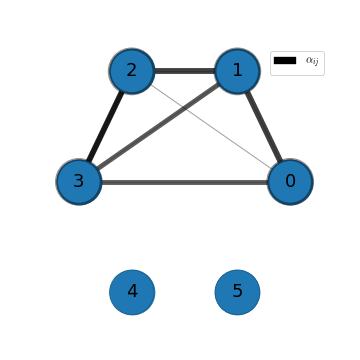

In [ ]:
group = "12"
session = "3"
begin_onset = 570
num_segs = 8 
end_onset = begin_onset + (15*num_segs)
seg_size = 15
onsets = [str(i) for i in range(begin_onset, end_onset, seg_size)]
offsets = [str(i+seg_size) for i in range(begin_onset, end_onset, seg_size)]
edge_key = "attn3" 

figsize = (5, 5)

contiguous_plots(figsize, group, session, onsets, offsets, edge_key, normalize=True, headagg_sum=False, log_norm=True, save=False, mode="dynamics")

In [32]:
# Function to get the data for segments wiht highest/lowest four arousal and valence
def get_top4emo_segments(group, session, num_segments=4, mode="highest", normalize=True, headagg_sum=False):
    group_data = get_graph_data_for(group, session)
    # remove key 'group_size' from the list of keys
    onsets_offsets = [k for k, v in group_data.items() if k != "group_size"]
    onsets_offsets = np.array([ts.split("_") for ts in onsets_offsets])
    # Get onsets and offsets
    onsets = onsets_offsets[:, 0]
    offsets = onsets_offsets[:, 1]
    
    
    # Get data for all segments
    all_segments = []
    for onset, offset in zip(onsets, offsets):
        edge_index, edge_weights, gt_dict, pred_dict, group_size = get_edge_data_for(group, session, onset, offset, normalize=normalize, headagg_sum=headagg_sum)
        all_segments.append((onset, offset, gt_dict["arousal"], gt_dict["valence"], group_size))
    
    # Sort segments by average of arousal and valence
    sorted_segments = sorted(all_segments, key=lambda x: (x[2], x[3]), reverse=True if mode=="highest" else False)
    
    # Get the top segments
    onsets = []
    offsets = []
    
    if mode == "medium":
        # get segments where round(arousal,1) and round(valence,1) = 0.5
        # get the segments where arousal and valence are closest to 0.5
        top_segments = []
        for segment in sorted_segments:
            if len(top_segments) >= num_segments:
                break
            if round(segment[2], 1) == 0.5 and round(segment[3], 1) == 0.5:
                top_segments.append(segment)        
    else:
        top_segments = sorted_segments[:num_segments]
    
    for segment in top_segments:
        onsets.append(segment[0])
        offsets.append(segment[1])
    
    return onsets, offsets

************************* HIGHEST 4 segments of arousal and valence *************************







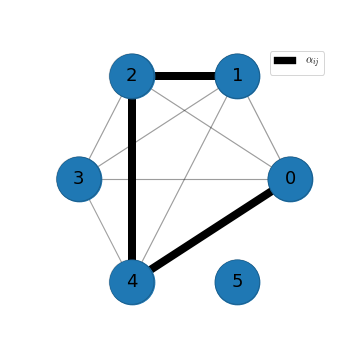
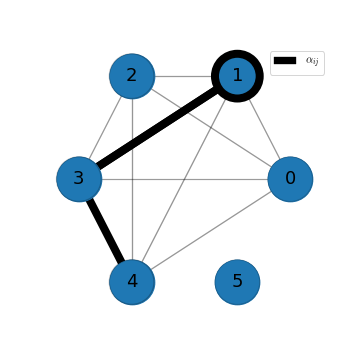
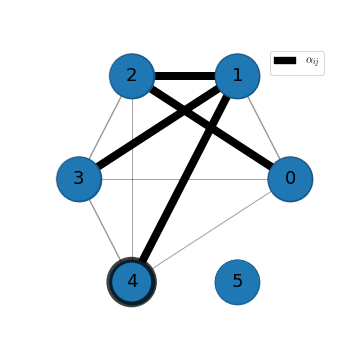
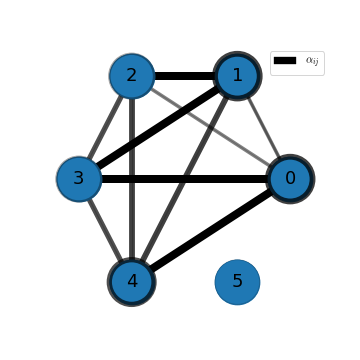

************************* LOWEST 4 segments of arousal and valence *************************







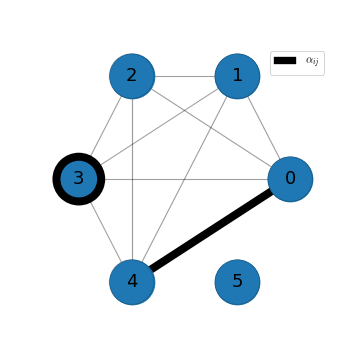
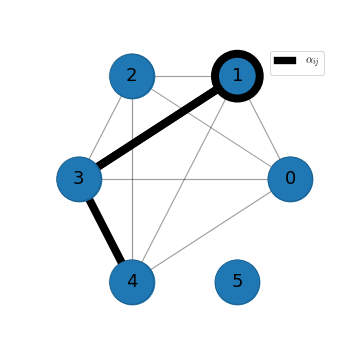
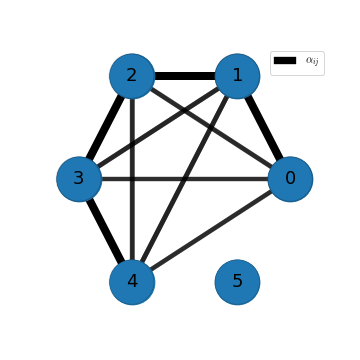
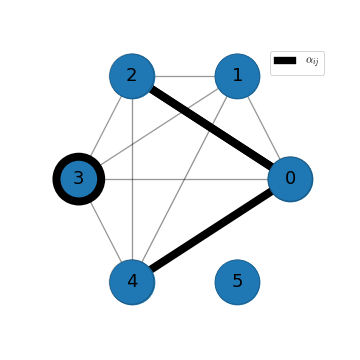

************************* MEDIUM 4 segments of arousal and valence *************************







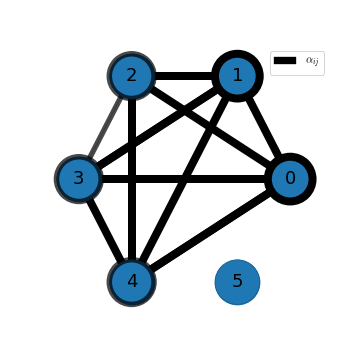
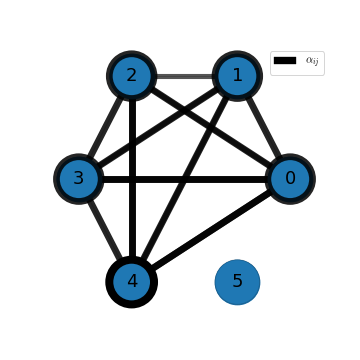
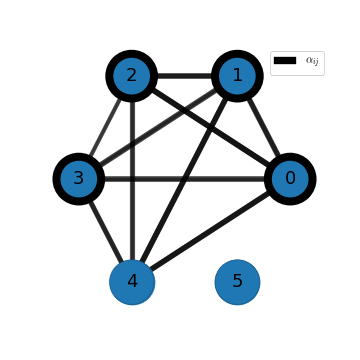
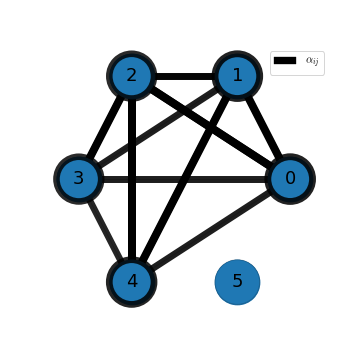

In [ ]:
#11_1
group = "11"
session = "1"
figsize = (5,5)
normalize = False
headagg_sum = False
num_segments = 4
att_key = "attn3" 

# Get the HIGHEST 4 segments of arousal and valence
print("*"*25, "HIGHEST 4 segments of arousal and valence", "*"*25)
req_onsets, req_offsets = get_top4emo_segments(group, session, num_segments=num_segments, mode="highest", normalize=normalize, headagg_sum=headagg_sum)
# Plotting the segments with highest arousal and valence
# contiguous_plots(figsize, group, session, req_onsets, req_offsets, "attn1", normalize=normalize, headagg_sum=headagg_sum)
# contiguous_plots(figsize, group, session, req_onsets, req_offsets, "attn2", normalize=normalize, headagg_sum=headagg_sum)
# contiguous_plots(figsize, group, session, req_onsets, req_offsets, "attn3", normalize=normalize, headagg_sum=headagg_sum)
contiguous_plots(figsize, group, session, req_onsets, req_offsets, att_key, normalize=normalize, headagg_sum=headagg_sum, log_norm=False, save=False, mode="highest")

print("*"*25, "LOWEST 4 segments of arousal and valence", "*"*25)
req_onsets, req_offsets = get_top4emo_segments(group, session, num_segments=num_segments, mode="lowest", normalize=normalize, headagg_sum=headagg_sum)
# # Plotting the segments with highest arousal and valence
# # contiguous_plots(figsize, group, session, req_onsets, req_offsets, "attn1", normalize=normalize, headagg_sum=headagg_sum)
# # contiguous_plots(figsize, group, session, req_onsets, req_offsets, "attn2", normalize=normalize, headagg_sum=headagg_sum)
# # contiguous_plots(figsize, group, session, req_onsets, req_offsets, "attn3", normalize=normalize, headagg_sum=headagg_sum)
contiguous_plots(figsize, group, session, req_onsets, req_offsets, att_key, normalize=normalize, headagg_sum=headagg_sum, log_norm=False, save=False, mode="lowest")

print("*"*25, "MEDIUM 4 segments of arousal and valence", "*"*25)
req_onsets, req_offsets = get_top4emo_segments(group, session, num_segments=num_segments, mode="medium", normalize=normalize, headagg_sum=headagg_sum)
# # Plotting the segments with highest arousal and valence
# # contiguous_plots(figsize, group, session, req_onsets, req_offsets, "attn1", normalize=normalize, headagg_sum=headagg_sum)
# # contiguous_plots(figsize, group, session, req_onsets, req_offsets, "attn2", normalize=normalize, headagg_sum=headagg_sum)
# # contiguous_plots(figsize, group, session, req_onsets, req_offsets, "attn3", normalize=normalize, headagg_sum=headagg_sum)
contiguous_plots(figsize, group, session, req_onsets, req_offsets, att_key, normalize=normalize, headagg_sum=headagg_sum, log_norm=False, save=False, mode="medium")

In [12]:
def normalize_only_reqweights(edge_weights, group_size, log_norm=False):
    
    num_dummy_nodes = c.MAX_GROUP_SIZE - group_size
    # Extract weights for visualization
    req_weights = edge_weights if num_dummy_nodes == 0 else edge_weights[:-1*num_dummy_nodes]  # Exclude dummy self-loops 
    # Normalize weights
    req_weights = req_weights  # Exponential scaling
    norm_weights = normalize_weights(req_weights, log_norm=log_norm)
    
    return norm_weights, req_weights

def get_segments_edge_stats(groups, sessions, edge_key="attn1", normalize=False, headagg_sum=False):
    # Get the segments for all groups and sessions
    all_segments = []
    for group in groups:
        for session in sessions:
            group_data = get_graph_data_for(group, session)
            # remove key 'group_size' from the list of keys
            onsets_offsets = [k for k, v in group_data.items() if k != "group_size"]
            onsets_offsets = np.array([ts.split("_") for ts in onsets_offsets])
            # Get onsets and offsets
            onsets = onsets_offsets[:, 0]
            offsets = onsets_offsets[:, 1]

            # Get data for all segments
            for onset, offset in zip(onsets, offsets):
                edge_index, edge_weights, gt_dict, pred_dict, group_size = get_edge_data_for(group, session, onset, offset, edge_key=edge_key, normalize=normalize, headagg_sum=headagg_sum)
                
                # Normalize weights
                norm_weights, req_weights = normalize_only_reqweights(edge_weights, group_size, log_norm=False)
                norm_edges_mean = np.mean(norm_weights)
                norm_edges_std = np.std(norm_weights)
                norm_edges_median = np.median(norm_weights)

                # No-norm weights
                edges_mean = np.mean(req_weights)
                edges_std = np.std(req_weights)
                edges_median = np.median(req_weights)
                
                all_segments.append((onset, offset, norm_edges_mean, norm_edges_std, norm_edges_median,
                                                    edges_mean, edges_std, edges_median, 
                                                    gt_dict["arousal"], gt_dict["valence"], pred_dict["arousal"], pred_dict["valence"], group_size))
    
    return all_segments


In [13]:
all_segments_g10 = get_segments_edge_stats(["10"], ["1", "2", "3"], edge_key="attn2", normalize=False, headagg_sum=False)
all_segments_g11 = get_segments_edge_stats(["11"], ["1", "2", "3"], edge_key="attn2", normalize=False, headagg_sum=False)
all_segments_g12 = get_segments_edge_stats(["12"], ["1", "2", "3"], edge_key="attn2", normalize=False, headagg_sum=False)

In [ ]:
import matplotlib.colors as mcolors
from matplotlib import cm, colors

def plot_arousal_valence_scatter(segments, stat="norm_edges_std", save=False):
    
    figsize = (15, 15)
    plt.figure(figsize=figsize)
    cb_title = r'$\sigma(\alpha_{ij})$' if "std" in stat else r'$\mu(\alpha_{ij})$'
    # Create a DataFrame from the list of tuples
    df = pd.DataFrame(segments, columns=["onset", "offset", "norm_edges_mean", "norm_edges_std", "norm_edges_median",\
                                                            "edges_mean", "edges_std", "edges_median",\
                                                            "gt_arousal", "gt_valence", "pred_arousal", "pred_valence", "group_size"])
    # stat_df = np.exp2(df[stat]+10)
    stat_df = np.expm1(df[stat])
    
    # Color the scatter plot based on edge_stat in the log scale map
    cmap = plt.get_cmap("viridis_r")  # Change the colormap as needed
    
    norm = mcolors.Normalize(vmin=stat_df.min(), vmax=stat_df.max())
    scatter = plt.scatter(df["gt_arousal"], df["gt_valence"], c=stat_df, alpha=0.9, s=200, cmap=cmap, norm=norm)
    plt.colorbar(scatter, label=cb_title, pad=0.01)

    med1_ellipse = Ellipse(xy=(0.4, 0.48), width=0.32, height=0.18, edgecolor='r', fc='None', lw=8, angle=50, ls='--')
    low_ellipse = Ellipse(xy=(0.475, 0.275), width=0.45, height=0.18, edgecolor='b', fc='None', lw=6, angle=25, ls=':')
    high_ellipse = Ellipse(xy=(0.75, 0.75), width=0.55, height=0.18, edgecolor='b', fc='None', lw=6, angle=45, ls=':')

    ax = plt.gca()
    ax.add_patch(med1_ellipse)
    ax.add_patch(low_ellipse)
    ax.add_patch(high_ellipse)

    plt.xlabel("Valence")
    plt.xticks(np.arange(0.1, 1., 0.1))
    plt.yticks(np.arange(0.1, 1., 0.1))
    
    plt.ylabel("Arousal")
    plt.grid(True)
    
    set_plot_params(plt, figsize=figsize)
    
    if save:
        plt.savefig(f"plots/av_scatter_{stat}.pdf", bbox_inches='tight')
    
    # Show the plot
    plt.show()
    plt.close()

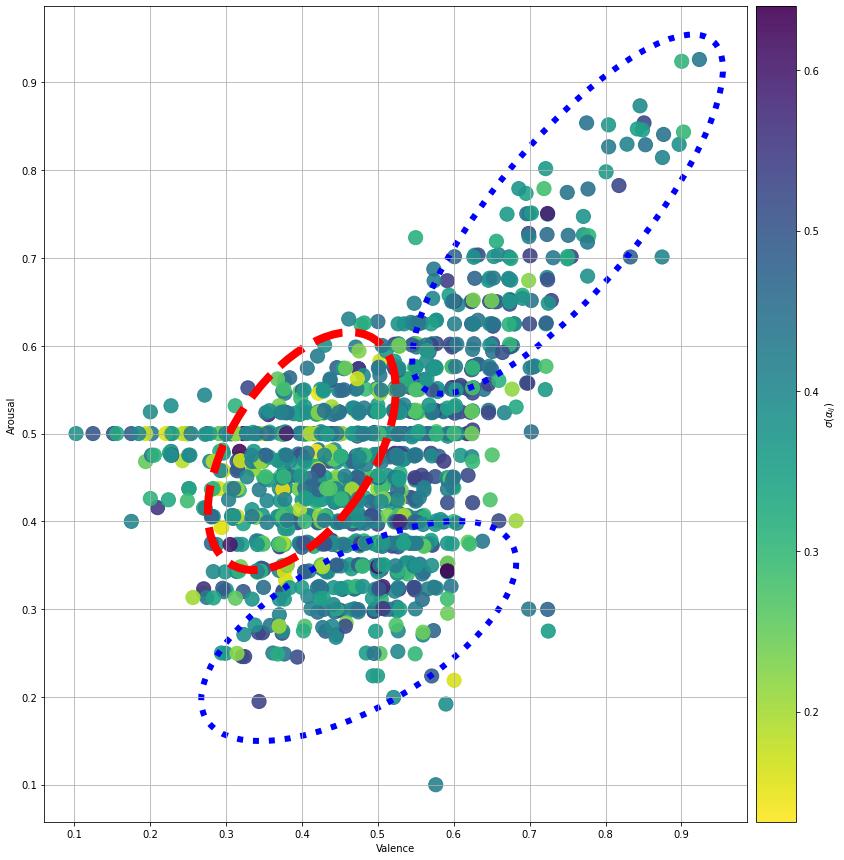

In [16]:
plot_arousal_valence_scatter(all_segments_g12+all_segments_g11+all_segments_g10, stat="norm_edges_std", save=True)

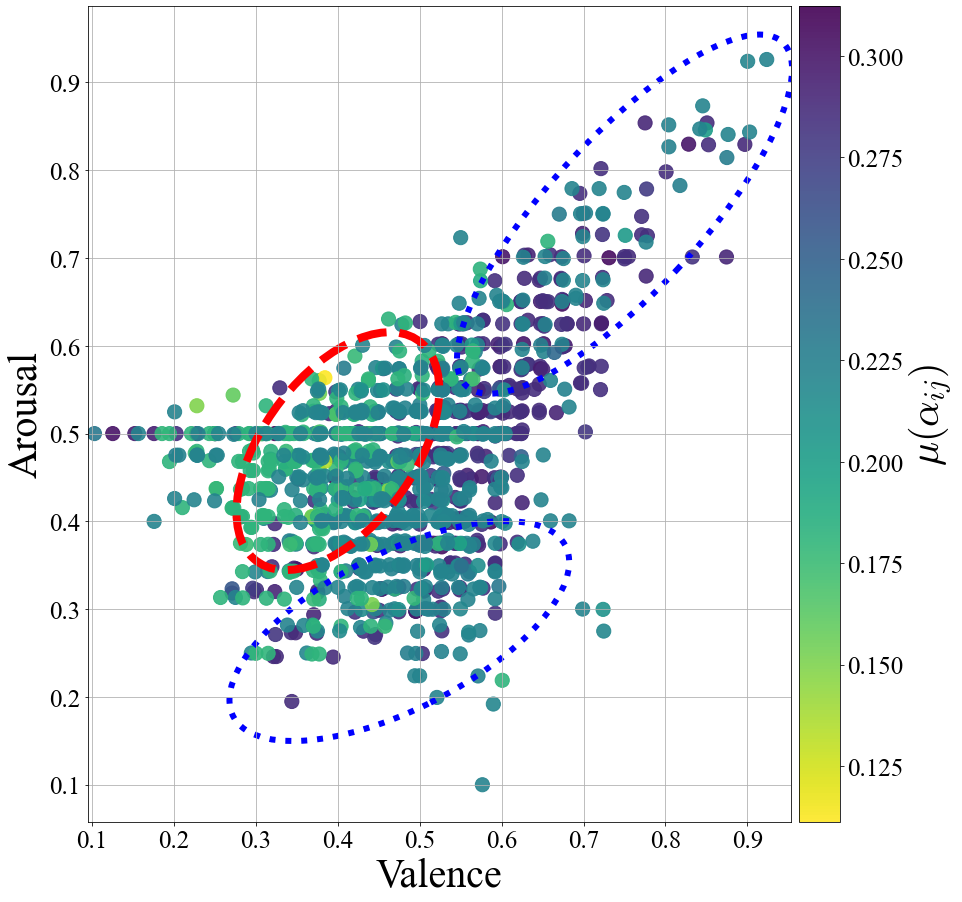

In [17]:
plot_arousal_valence_scatter(all_segments_g12+all_segments_g11+all_segments_g10, stat="edges_median", save=False)

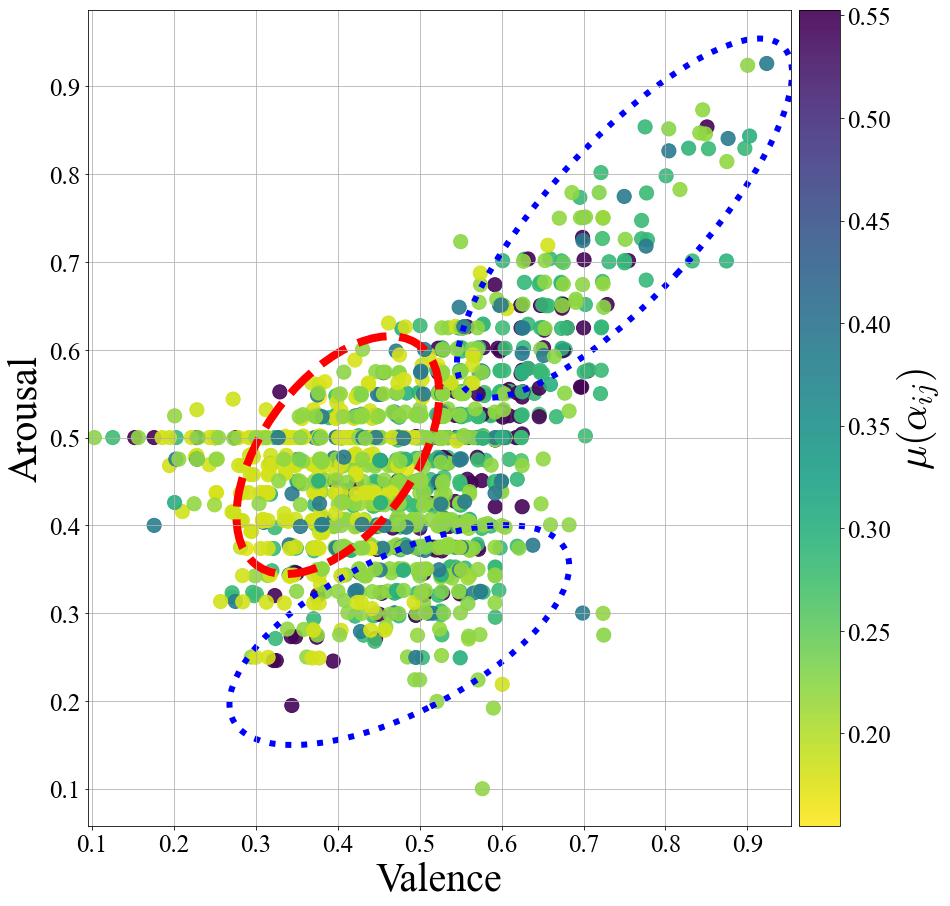

In [18]:
plot_arousal_valence_scatter(all_segments_g12+all_segments_g11+all_segments_g10, stat="edges_mean", save=True)